In [ ]:
# # # cheking the number of cored this system has.
# !cat /proc/cpuinfo | grep "cpu cores" | uniq

# # GPU info
# !nvidia-smi

# # Amount of system RAM available to be used.
# from psutil import virtual_memory
# ram_gb = virtual_memory().total / (1024 * 1024 * 1024)   
# print('Your runtime has {:.1f} gigabyte of availabe\n'.format(ram_gb))

# #finding the recursion limit to avoid Augmentation recursion error 
# import sys
# print(sys.getrecursionlimit())

# #installing fastai
# !pip install torch===1.4.0 torchvision===0.5.0 -f https://download.pytorch.org/whl/torch_stable.html

In [ ]:
#importing libraries and initializing fastai 
import pandas as pd 
import numpy as np 
import time

#Mounting google drive for saving the models after training 
from google.colab import drive
drive.mount('/content/drive')

from fastai.vision import *
from fastai.metrics import error_rate

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#loading the data 
#There are NaN values in the consumer_complaint_narrative column
train_raw = pd.read_csv('/content/drive/MyDrive/MS_Final_Project/Dataset_Ref/consumer_complaints.csv')
train_raw.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (5,11) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,date_received,product,sub_product,issue,sub_issue,consumer_complaint_narrative,company_public_response,company,state,zipcode,tags,consumer_consent_provided,submitted_via,date_sent_to_company,company_response_to_consumer,timely_response,consumer_disputed?,complaint_id
0,08/30/2013,Mortgage,Other mortgage,"Loan modification,collection,foreclosure",NaN,NaN,NaN,U.S. Bancorp,CA,95993,NaN,NaN,Referral,09/03/2013,Closed with explanation,Yes,Yes,511074
1,08/30/2013,Mortgage,Other mortgage,"Loan servicing, payments, escrow account",NaN,NaN,NaN,Wells Fargo & Company,CA,91104,NaN,NaN,Referral,09/03/2013,Closed with explanation,Yes,Yes,511080
2,08/30/2013,Credit reporting,NaN,Incorrect information on credit report,Account status,NaN,NaN,Wells Fargo & Company,NY,11764,NaN,NaN,Postal mail,09/18/2013,Closed with explanation,Yes,No,510473
3,08/30/2013,Student loan,Non-federal student loan,Repaying your loan,Repaying your loan,NaN,NaN,"Navient Solutions, Inc.",MD,21402,NaN,NaN,Email,08/30/2013,Closed with explanation,Yes,Yes,510326
4,08/30/2013,Debt collection,Credit card,False statements or representation,Attempted to collect wrong amount,NaN,NaN,Resurgent Capital Services L.P.,GA,30106,NaN,NaN,Web,08/30/2013,Closed with explanation,Yes,Yes,511067


In [ ]:
#Training data shape
train_raw.shape

(555957, 18)

In [ ]:
#Preprocessing the data 
#Extracting only those data whose consumer_complaint_narrative column is not null
#columns = 18
train_raw = train_raw[train_raw.consumer_complaint_narrative.notnull()]
train_raw.shape

(66806, 18)

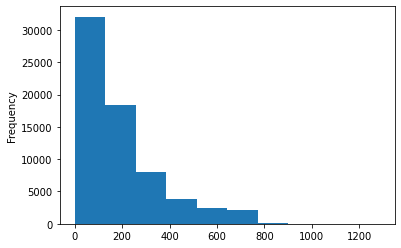

In [ ]:
#It splits the string into , separated values 
train_raw.consumer_complaint_narrative.apply(lambda x:len(x.split())).plot(kind='hist')

In [ ]:
train_raw['len_txt'] =train_raw.consumer_complaint_narrative.apply(lambda x: len(x.split()))

In [ ]:
train_raw.describe()

,complaint_id,len_txt
count,6.680600e+04,66806.000000
mean,1.571665e+06,190.644014
std,1.545692e+05,166.830597
min,1.290181e+06,1.000000
25%,1.443264e+06,71.000000
50%,1.569485e+06,136.000000
75%,1.702750e+06,254.000000
max,1.888608e+06,1284.000000


In [ ]:
train_raw.columns

Index(['date_received', 'product', 'sub_product', 'issue', 'sub_issue',
       'consumer_complaint_narrative', 'company_public_response', 'company',
       'state', 'zipcode', 'tags', 'consumer_consent_provided',
       'submitted_via', 'date_sent_to_company', 'company_response_to_consumer',
       'timely_response', 'consumer_disputed?', 'complaint_id', 'len_txt'],
      dtype='object')

In [ ]:
train_raw.shape

(66806, 19)

In [ ]:
#Select only the rows with more than 250 words 
train_raw = train_raw[train_raw.len_txt >249]
train_raw.shape

(17142, 19)

In [ ]:
train_raw.head()

,date_received,product,sub_product,issue,sub_issue,consumer_complaint_narrative,company_public_response,company,state,zipcode,tags,consumer_consent_provided,submitted_via,date_sent_to_company,company_response_to_consumer,timely_response,consumer_disputed?,complaint_id,len_txt
190155,03/19/2015,Mortgage,Conventional fixed mortgage,"Loan modification,collection,foreclosure",NaN,In XX/XX/XXXX my wages that I earned at my job...,NaN,Wells Fargo & Company,CA,946XX,NaN,Consent provided,Web,03/19/2015,Closed with explanation,Yes,Yes,1290524,666
190208,03/19/2015,Mortgage,Conventional fixed mortgage,Credit decision / Underwriting,NaN,XXXX was submitted XX/XX/XXXX. At the time I s...,NaN,Rushmore Loan Management Services LLC,CA,956XX,Older American,Consent provided,Web,03/19/2015,Closed with explanation,Yes,Yes,1292137,259
190251,03/19/2015,Mortgage,Conventional fixed mortgage,"Loan servicing, payments, escrow account",NaN,I spoke to XXXX of green tree representatives ...,NaN,Ditech Financial LLC,CA,948XX,NaN,Consent provided,Web,03/19/2015,Closed with non-monetary relief,Yes,No,1290534,301
190263,03/19/2015,Credit card,NaN,Other,NaN,i opened XXXX Bank of America credit cards 15-...,Company chooses not to provide a public response,Bank of America,OR,971XX,NaN,Consent provided,Web,03/19/2015,Closed with monetary relief,Yes,Yes,1292209,780
190264,03/19/2015,Consumer Loan,Vehicle loan,Taking out the loan or lease,NaN,I applied for a loan with XXXX XXXX and had pu...,NaN,Hyundai Capital America,MS,392XX,NaN,Consent provided,Web,03/19/2015,Closed with explanation,Yes,No,1292159,558


In [ ]:
#selecting only the consumer_complaint_narrative and product columns
train_raw=train_raw[['consumer_complaint_narrative','product']]
train_raw.reset_index(inplace=True, drop=True)
train_raw.head()

,consumer_complaint_narrative,product
0,In XX/XX/XXXX my wages that I earned at my job...,Mortgage
1,XXXX was submitted XX/XX/XXXX. At the time I s...,Mortgage
2,I spoke to XXXX of green tree representatives ...,Mortgage
3,i opened XXXX Bank of America credit cards 15-...,Credit card
4,I applied for a loan with XXXX XXXX and had pu...,Consumer Loan


In [ ]:
train_raw['product'].unique()

array(['Mortgage', 'Credit card', 'Consumer Loan', 'Debt collection', 'Credit reporting', 'Student loan',
       'Bank account or service', 'Money transfers', 'Payday loan', 'Prepaid card', 'Other financial service'],
      dtype=object)

In [ ]:
#group similar products  dataframe.at = accessing a value using row column pair 
train_raw.at[train_raw['product']=='Credit reporting','product']= 'Credit reporting, credit repair services, or other personal consumer reports'
train_raw.at[train_raw['product'] == 'Credit card', 'product'] = 'Credit card or prepaid card'
train_raw.at[train_raw['product'] == 'Prepaid card', 'product'] = 'Credit card or prepaid card'
train_raw.at[train_raw['product'] == 'Payday loan', 'product'] = 'Payday loan, title loan, or personal loan'
train_raw.at[train_raw['product'] == 'Virtual currency', 'product'] = 'Money transfer, virtual currency, or money service'
train_raw.head()

,consumer_complaint_narrative,product
0,In XX/XX/XXXX my wages that I earned at my job...,Mortgage
1,XXXX was submitted XX/XX/XXXX. At the time I s...,Mortgage
2,I spoke to XXXX of green tree representatives ...,Mortgage
3,i opened XXXX Bank of America credit cards 15-...,Credit card or prepaid card
4,I applied for a loan with XXXX XXXX and had pu...,Consumer Loan


In [ ]:
train_raw['product'].unique()

array(['Mortgage', 'Credit card or prepaid card', 'Consumer Loan', 'Debt collection',
       'Credit reporting, credit repair services, or other personal consumer reports', 'Student loan',
       'Bank account or service', 'Money transfers', 'Payday loan, title loan, or personal loan',
       'Other financial service'], dtype=object)

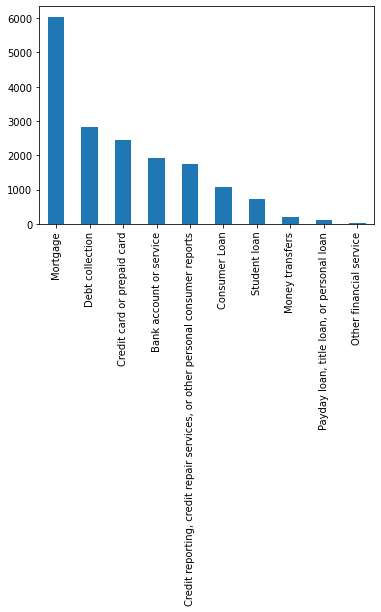

In [ ]:
train_raw['product'].value_counts().sort_values(ascending=False).plot(kind='bar')
#unbalanced dataset 

In [ ]:
#Renaming the columns 
train_raw=train_raw.rename(columns = {'consumer_complaint_narrative':'text', 'product':'label'})
train_raw.head()

,text,label
0,In XX/XX/XXXX my wages that I earned at my job...,Mortgage
1,XXXX was submitted XX/XX/XXXX. At the time I s...,Mortgage
2,I spoke to XXXX of green tree representatives ...,Mortgage
3,i opened XXXX Bank of America credit cards 15-...,Credit card or prepaid card
4,I applied for a loan with XXXX XXXX and had pu...,Consumer Loan


In [ ]:
#changing the categorical value column to integers

from sklearn.preprocessing import LabelEncoder

LE = LabelEncoder()
train_raw['label'] = LE.fit_transform(train_raw['label'])
train_raw.head()

,text,label
0,In XX/XX/XXXX my wages that I earned at my job...,6
1,XXXX was submitted XX/XX/XXXX. At the time I s...,6
2,I spoke to XXXX of green tree representatives ...,6
3,i opened XXXX Bank of America credit cards 15-...,2
4,I applied for a loan with XXXX XXXX and had pu...,1


In [ ]:
len(np.unique(train_raw['label']))

10

In [ ]:
#creating the copy of the dataframe
#dataframe.copy(deep=True)  ==> This will create a copy and any changes to the copy will not be reflected in the original df
train = train_raw.copy()

In [ ]:
#reindexing to create randomness 
train = train.reindex(np.random.permutation(train.index))
train.head()

,text,label
9680,"My wife and I went to Huntington Bank, applied...",6
15741,I disputed fraudulent charges on my credit car...,2
15554,"To Whom It May Concern, Here is a summary of e...",6
10650,Upon reviewing my Bank of America checking acc...,0
15076,On Tuesday XXXX XXXX I spoke with a representa...,6


In [ ]:
#remove the non-alphanumeric characters from the text 
import re 
def clean_txt(text):
  text = re.sub("'", "",text)
  text=re.sub("(\\W)+"," ",text)     #() -- to match the sequence inside it , \-- to escape the special characters , 
                                     #\W -- get all the nonalphanumeric characters, + --all the instances 

  return text

In [ ]:
train['text']  = train.text.apply(clean_txt)
train.head()

,text,label
9680,My wife and I went to Huntington Bank applied ...,6
15741,I disputed fraudulent charges on my credit car...,2
15554,To Whom It May Concern Here is a summary of ev...,6
10650,Upon reviewing my Bank of America checking acc...,0
15076,On Tuesday XXXX XXXX I spoke with a representa...,6


In [ ]:
train.reset_index(drop=True, inplace=True)
train.head(2)

,text,label
0,My wife and I went to Huntington Bank applied ...,6
1,I disputed fraudulent charges on my credit car...,2


In [ ]:
train.shape

(17142, 2)

In [ ]:
# val.reset_index(drop=True, inplace=True)
# val.head(2)

In [ ]:
# val.shape, train.shape

In [ ]:
!pip install tensorflow==2.5.0

In [ ]:
#Installing the BERT module
!pip install bert-tensorflow
#!pip install bert-for-tf2

import bert
from bert import optimization

!pip install -q tf-models-official==2.4.0

import os

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

import tensorflow_hub as hub
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

In [ ]:
print(tf.__version__)

2.5.0



# Setting The Output Directory for BERT



In [ ]:
#Setting the output directory for BERT 
# Set the output directory for saving model file
OUTPUT_DIR = '/content/drive/MyDrive/MS_Final_Project/Model_checkpoints_CC'

#@markdown Whether or not to clear/delete the directory and create a new one
DO_DELETE = True #@param {type:"boolean"}

if DO_DELETE:
  try:
    tf.io.gfile.DeleteRecursively(OUTPUT_DIR)#deletes everything under the directory recursively
  except:
    pass

tf.io.gfile.makedirs(OUTPUT_DIR) #Creates a directory and all parent/intermediate directories.
print('***** Model output directory: {} *****'.format(OUTPUT_DIR))

***** Model output directory: /content/drive/MyDrive/MS_Final_Project/Model_checkpoints_CC *****


In [ ]:
print("Training Set Shape :", train.shape)
#print("Validation Set Shape :", val.shape)
# print("Test Set Shape :", test.shape)

Training Set Shape : (17142, 2)


In [ ]:
DATA_COLUMN = 'text'
LABEL_COLUMN = 'label'
# The list containing all the classes (train['SECTION'].unique())
label_list = [x for x in np.unique(train.label)]
label_list

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

# Splitting the Data into smaller chunks

In [ ]:
#Splitting the data into smaller chunks 
def get_split(text1):
  l_total = []
  l_parcial = []
  if len(text1.split())//150 >0:
    n = len(text1.split())//150
  else: 
    n = 1
  for w in range(n):
    if w == 0:
      l_parcial = text1.split()[:200]
      l_total.append(" ".join(l_parcial))
    else:
      l_parcial = text1.split()[w*150:w*150 + 200] #overlapping 50 words in every chunks 
      l_total.append(" ".join(l_parcial))
  return l_total

In [ ]:
def get_split_count(text1):
  if len(text1.split())//150 >0:
    n = len(text1.split())//150
  else: 
    n = 1
  return n

In [ ]:
train['text_split'] = train[DATA_COLUMN].apply(get_split)
train.head()

,text,label,text_split
0,My wife and I went to Huntington Bank applied ...,6,[My wife and I went to Huntington Bank applied...
1,I disputed fraudulent charges on my credit car...,2,[I disputed fraudulent charges on my credit ca...
2,To Whom It May Concern Here is a summary of ev...,6,[To Whom It May Concern Here is a summary of e...
3,Upon reviewing my Bank of America checking acc...,0,[Upon reviewing my Bank of America checking ac...
4,On Tuesday XXXX XXXX I spoke with a representa...,6,[On Tuesday XXXX XXXX I spoke with a represent...


In [ ]:
train['text_split_count'] = train[DATA_COLUMN].apply(get_split_count)
train.head()

,text,label,text_split,text_split_count
0,My wife and I went to Huntington Bank applied ...,6,[My wife and I went to Huntington Bank applied...,4
1,I disputed fraudulent charges on my credit car...,2,[I disputed fraudulent charges on my credit ca...,2
2,To Whom It May Concern Here is a summary of ev...,6,[To Whom It May Concern Here is a summary of e...,3
3,Upon reviewing my Bank of America checking acc...,0,[Upon reviewing my Bank of America checking ac...,1
4,On Tuesday XXXX XXXX I spoke with a representa...,6,[On Tuesday XXXX XXXX I spoke with a represent...,3


In [ ]:
train.shape

(17142, 4)

In [ ]:
count_1 =0
count_2 =0
count_3 =0
count_4 =0
count_5 =0
for i in train['text_split_count']:
  if i==5:
    count_5+=1
  if i==1:
    count_1+=1
  if i==2:
    count_2+=1
  if i==3:
    count_3+=1
  if i==4:
    count_4+=1

In [ ]:
print('count_1 ', count_1)
print('count_2 ', count_2)
print('count_3 ', count_3)
print('count_4 ', count_4)
print('count_5 ', count_5)

count_1  4045
count_2  6873
count_3  3264
count_4  2758
count_5  202


In [ ]:
#creating the test set
test_set = train[(train['text_split_count'] == 5)]

In [ ]:
test_set

,text,label,text_split,text_split_count
94,I took out a loan in XXXX XXXX that is being s...,9,[I took out a loan in XXXX XXXX that is being ...,5
132,Well the first step I went to XXXX in XXXX XXX...,1,[Well the first step I went to XXXX in XXXX XX...,5
307,I called Making homes affordable last night ag...,6,[I called Making homes affordable last night a...,5
325,I d like to complain about the way Bank of Ame...,6,[I d like to complain about the way Bank of Am...,5
372,I first contacted PNC to get a mortgage and my...,6,[I first contacted PNC to get a mortgage and m...,5
...,...,...,...,...
16554,This complaint is regarding SYNCHRONY FINANCIA...,2,[This complaint is regarding SYNCHRONY FINANCI...,5
16846,I lost my home of 25 years to a preditory lend...,6,[I lost my home of 25 years to a preditory len...,5
16868,I encountered a hardship situation XX XX XXXX ...,6,[I encountered a hardship situation XX XX XXXX...,5
16893,I went into a local XXXX office to let them he...,2,[I went into a local XXXX office to let them h...,5


In [ ]:
train.shape , test_set.shape

((17142, 4), (202, 4))

In [ ]:
train = train[(train['text_split_count'].isin([1,2,3,4]))]

In [ ]:
train.shape

(16940, 4)

In [ ]:
from sklearn.model_selection import train_test_split
train, val = train_test_split(train, test_size=0.2, random_state=35)
train.head()

,text,label,text_split,text_split_count
12325,I requested detailed accounting of payments ch...,3,[I requested detailed accounting of payments c...,2
12032,Citibank offered to me as consideration a bonu...,2,[Citibank offered to me as consideration a bon...,3
1160,I have been using Chase Freedom credit card si...,2,[I have been using Chase Freedom credit card s...,1
1283,XX XX XXXX after numerous challenges including...,3,[XX XX XXXX after numerous challenges includin...,1
10129,Today I am requesting assistance with several ...,6,[Today I am requesting assistance with several...,3


In [ ]:
train.shape, val.shape, test_set.shape

((13552, 4), (3388, 4), (202, 4))

In [ ]:
train_l = []
label_l = []
index_l =[]
for idx,row in train.iterrows():
  for l in row['text_split']:  #it is going to create list of training chunks with label and index mapping 
    train_l.append(l)
    label_l.append(row['label'])
    index_l.append(idx)
len(train_l), len(label_l), len(index_l)

(30880, 30880, 30880)

In [ ]:
val_l = []
val_label_l = []
val_index_l = []
for idx,row in val.iterrows():
  for l in row['text_split']:
    val_l.append(l)
    val_label_l.append(row['label'])
    val_index_l.append(idx)
len(val_l), len(val_label_l), len(val_index_l)

(7735, 7735, 7735)

In [ ]:
test_l = []
test_label_l = []
test_index_l = []
for idx,row in test_set.iterrows():
  for l in row['text_split']:
    test_l.append(l)
    test_label_l.append(row['label'])
    test_index_l.append(idx)
len(test_l), len(test_label_l), len(test_index_l)

(1010, 1010, 1010)

In [ ]:
train_df = pd.DataFrame({DATA_COLUMN:train_l, LABEL_COLUMN:label_l})
train_df.head()

,text,label
0,I requested detailed accounting of payments ch...,3
1,not They chose only to update the account even...,3
2,Citibank offered to me as consideration a bonu...,2
3,s offer Specifically when I attempted to purch...,2
4,in person and purchase a phone in store This r...,2


In [ ]:
val_df = pd.DataFrame({DATA_COLUMN:val_l, LABEL_COLUMN:val_label_l})
val_df.head()

,text,label
0,I decided to invest my money with Raymond Jame...,0
1,of times I would not suffer more than a 10 los...,0
2,I received an email yesterday XXXX XXXX 15 sta...,8
3,I received a phone call from a representative ...,4
4,states otherwise It clearly states I have 30 d...,4


In [ ]:
test_df = pd.DataFrame({DATA_COLUMN:test_l, LABEL_COLUMN:test_label_l})
test_df.head()

,text,label
0,I took out a loan in XXXX XXXX that is being s...,9
1,know it would nt be sent because my loan could...,9
2,used XXXX months in XX XX XXXX the rep told me...,9
3,ACS rep told me they legally could not stop th...,9
4,I informed her this was again ACS modifying pe...,9


In [ ]:
print('train_df shape : ',train_df.shape)
print('val_df shape : ',val_df.shape)
print('test_df shape : ',test_df.shape)

train_df shape :  (30880, 2)
val_df shape :  (7735, 2)
test_df shape :  (1010, 2)


# BERT: Data Preprocessing

In [ ]:
class PaddingInputExample(object):
      pass

class InputExample(object):
    """A single training/test example for simple sequence classification."""

    def __init__(self, guid, text_a, text_b=None, label=None):
        
        """Constructs a InputExample.
    Args:
      guid: Unique id for the example.
      text_a: string. The untokenized text of the first sequence. For single
        sequence tasks, only this sequence must be specified.
      text_b: (Optional) string. The untokenized text of the second sequence.
        Only must be specified for sequence pair tasks.
      label: (Optional) string. The label of the example. This should be
        specified for train and dev examples, but not for test examples.
    """
        self.guid = guid
        self.text_a = text_a
        self.text_b = text_b
        self.label = label

In [ ]:
train_InputExamples_1 = train_df.apply(lambda x: InputExample(guid=None,
                                                                  text_a = x[DATA_COLUMN], 
                                                                  text_b = None, 
                                                                  label = x[LABEL_COLUMN]), axis = 1)

In [ ]:
train_InputExamples_1

0        <__main__.InputExample object at 0x7fbadfbc81d0>
1        <__main__.InputExample object at 0x7fbadfbc8110>
2        <__main__.InputExample object at 0x7fbadfbbad50>
3        <__main__.InputExample object at 0x7fbadfbbaf50>
4        <__main__.InputExample object at 0x7fbadf8d0990>
                               ...                       
30875    <__main__.InputExample object at 0x7fbadf20b190>
30876    <__main__.InputExample object at 0x7fbadf20b1d0>
30877    <__main__.InputExample object at 0x7fbadf20b210>
30878    <__main__.InputExample object at 0x7fbadf20b250>
30879    <__main__.InputExample object at 0x7fbadf20b290>
Length: 30880, dtype: object

In [ ]:
print("Row 0 - guid of training set : ", train_InputExamples_1.iloc[0].guid)
print("\n__________\nRow 0 - text_a of training set : ", train_InputExamples_1.iloc[0].text_a)
print("\n__________\nRow 0 - text_b of training set : ", train_InputExamples_1.iloc[0].text_b)
print("\n__________\nRow 0 - label of training set : ", train_InputExamples_1.iloc[0].label)

Row 0 - guid of training set :  None

__________
Row 0 - text_a of training set :  I requested detailed accounting of payments charges along with an explanation of any charges how those fees were calculated copy of original contract with original creditor documentation on sale of the repossessed car amount applied to account copy of repossession papers in connection with a XXXX XXXX account showing up on my credit report I filed a dispute with TransUnion on XXXX XXXX 2015 they stated they received a letter that states simply that the account was accurate then made changes to XXXX dates there no was verification to prove the account is accurate valid included with the statement They did nt even receive verification showing the account is even my account no original signed contract with original creditor According to FCRA section 611 c if they did not receive the detailed verification that was requested showing the account is valid accurate they are required to remove it They did not The

In [ ]:
val_InputExamples_1 = val_df.apply(lambda x: InputExample(guid=None, 
                                                                   text_a = x[DATA_COLUMN], 
                                                                   text_b = None, 
                                                                   label = x[LABEL_COLUMN]), axis = 1)

In [ ]:
test_InputExamples_1 = test_df.apply(lambda x: InputExample(guid=None, 
                                                                   text_a = x[DATA_COLUMN], 
                                                                   text_b = None, 
                                                                   label = x[LABEL_COLUMN]), axis = 1)

# BERT: Loading the pre-trained model

In [ ]:
import official.nlp.bert.tokenization as tokenization

In [ ]:
# ##We are creatung the tokens to gorm the vocabulary which inturn is ued to represent the words
# #BERT: Loading the pre-trained model
# This is a path to an uncased (all lowercase) version of BERT
BERT_MODEL_HUB = "https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1"

def create_tokenizer_from_hub_module():
  """Get the vocab file and casing info from the Hub module."""
  with tf.Graph().as_default():
    bert_module = hub.Module(BERT_MODEL_HUB)
    tokenization_info = bert_module(signature="tokenization_info", as_dict=True)
    with tf.compat.v1.Session() as sess:
      vocab_file, do_lower_case = sess.run([tokenization_info["vocab_file"],
                                            tokenization_info["do_lower_case"]])
      
  return tokenization.FullTokenizer(
      vocab_file=vocab_file, do_lower_case=do_lower_case)

tokenizer = create_tokenizer_from_hub_module()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [ ]:
len(tokenizer.vocab.keys())

30522

In [ ]:
#Defining Input features 
class InputFeatures(object):
  """A single set of features of data."""

  def __init__(self,
               input_ids,
               input_mask,
               segment_ids,
               label_id,
               is_real_example=True):
    self.input_ids = input_ids
    self.input_mask = input_mask
    self.segment_ids = segment_ids
    self.label_id = label_id
    self.is_real_example = is_real_example

In [ ]:
def convert_single_example(tokenizer, example, max_seq_length=256):
    """Converts a single `InputExample` into a single `InputFeatures`."""

    if isinstance(example, PaddingInputExample):
        input_ids = [0] * max_seq_length
        input_mask = [0] * max_seq_length
        segment_ids = [0] * max_seq_length
        label = 0
        return input_ids, input_mask, segment_ids, label

    tokens_a = tokenizer.tokenize(example.text_a)
    if len(tokens_a) > max_seq_length - 2:
        tokens_a = tokens_a[0 : (max_seq_length - 2)]

    tokens = []
    segment_ids = []
    tokens.append("[CLS]")
    segment_ids.append(0)
    for token in tokens_a:
        tokens.append(token)
        segment_ids.append(0)
    tokens.append("[SEP]")
    segment_ids.append(0)

    input_ids = tokenizer.convert_tokens_to_ids(tokens)

    # The mask has 1 for real tokens and 0 for padding tokens. Only real
    # tokens are attended to.
    input_mask = [1] * len(input_ids)

    # Zero-pad up to the sequence length.
    while len(input_ids) < max_seq_length:
        input_ids.append(0)
        input_mask.append(0)
        segment_ids.append(0)

    assert len(input_ids) == max_seq_length
    assert len(input_mask) == max_seq_length
    assert len(segment_ids) == max_seq_length

    return input_ids, input_mask, segment_ids, example.label

In [ ]:
def convert_examples_to_features(tokenizer, examples, max_seq_length=200):
    """Convert a set of `InputExample`s to a list of `InputFeatures`."""

    input_ids, input_masks, segment_ids, labels,features = [], [], [], [],[]
    for example in tqdm.tqdm(examples, desc="Converting examples to features"):
        input_id, input_mask, segment_id, label = convert_single_example(
            tokenizer, example, max_seq_length
        )

        input_ids.append(input_id)
        input_masks.append(input_mask)
        segment_ids.append(segment_id)
        labels.append(label)

        feature = InputFeatures(input_ids=input_id,
        input_mask=input_mask,
        segment_ids=segment_id,
        label_id=label,
        is_real_example=True)

        features.append(feature)
    # return(
    #     np.array(input_ids),
    #     np.array(input_masks),
    #     np.array(segment_ids),
    #     np.array(labels).reshape(-1, 1),
    # )
    return features

In [ ]:
import tqdm
MAX_SEQ_LENGTH = 200

In [ ]:
# Convert our train and validation features to InputFeatures that BERT understands.

train_features = convert_examples_to_features(tokenizer, train_InputExamples_1, MAX_SEQ_LENGTH)

val_features = convert_examples_to_features(tokenizer, val_InputExamples_1, MAX_SEQ_LENGTH)

test_features = convert_examples_to_features(tokenizer, test_InputExamples_1, MAX_SEQ_LENGTH)

Converting examples to features: 100%|██████████| 1010/1010 [00:02<00:00, 336.68it/s]


In [ ]:
print("Sentence : ", train_InputExamples_1.iloc[0].text_a)
print("-"*30)
print("Tokens : ", tokenizer.tokenize(train_InputExamples_1.iloc[0].text_a))
print("-"*30)
print("Input IDs : ", train_features[0].input_ids)
print("-"*30)
print("Input Masks : ", train_features[0].input_mask)
print("-"*30)
print("Segment IDs : ", train_features[0].segment_ids)

Sentence :  I requested detailed accounting of payments charges along with an explanation of any charges how those fees were calculated copy of original contract with original creditor documentation on sale of the repossessed car amount applied to account copy of repossession papers in connection with a XXXX XXXX account showing up on my credit report I filed a dispute with TransUnion on XXXX XXXX 2015 they stated they received a letter that states simply that the account was accurate then made changes to XXXX dates there no was verification to prove the account is accurate valid included with the statement They did nt even receive verification showing the account is even my account no original signed contract with original creditor According to FCRA section 611 c if they did not receive the detailed verification that was requested showing the account is valid accurate they are required to remove it They did not They chose only to update the account even though they had not received an

In [ ]:
def create_model(is_predicting, input_ids, input_mask, segment_ids, labels,
                 num_labels):
  
  bert_module = hub.Module(
      BERT_MODEL_HUB,
      trainable=True)
  bert_inputs = dict(
      input_ids=input_ids,
      input_mask=input_mask,
      segment_ids=segment_ids)
  bert_outputs = bert_module(
      inputs=bert_inputs,
      signature="tokens",
      as_dict=True)

  # Use "pooled_output" for classification tasks on an entire sentence.
  # Use "sequence_outputs" for token-level output.
  output_layer = bert_outputs["pooled_output"]
  # with tf.Session() as sess:
  output_layer1 = bert_outputs["pooled_output"]
  # output_layer1 = 999
  hidden_size = output_layer.shape[-1]

  # Create our own layer to tune for politeness data.
  output_weights = tf.get_variable(
      "output_weights", [num_labels, hidden_size],
      initializer=tf.truncated_normal_initializer(stddev=0.02))

  output_bias = tf.get_variable(
      "output_bias", [num_labels], initializer=tf.zeros_initializer())

  with tf.variable_scope("loss"):

    # Dropout helps prevent overfitting
    output_layer = tf.nn.dropout(output_layer, keep_prob=0.8)

    logits = tf.matmul(output_layer, output_weights, transpose_b=True)
    logits = tf.nn.bias_add(logits, output_bias)
    log_probs = tf.nn.log_softmax(logits, axis=-1)

    # Convert labels into one-hot encoding
    one_hot_labels = tf.one_hot(labels, depth=num_labels, dtype=tf.float32)

    predicted_labels = tf.squeeze(tf.argmax(log_probs, axis=-1, output_type=tf.int32))
    # If we're predicting, we want predicted labels and the probabiltiies.
    if is_predicting:
      return (predicted_labels, log_probs, output_layer1)

    # If we're train/eval, compute loss between predicted and actual label
    per_example_loss = -tf.reduce_sum(one_hot_labels * log_probs, axis=-1)
    loss = tf.reduce_mean(per_example_loss)
    return (loss, predicted_labels, log_probs)

In [ ]:
def model_fn_builder(num_labels, learning_rate, num_train_steps,
                     num_warmup_steps):
  """Returns `model_fn` closure for TPUEstimator."""
  def model_fn(features, labels, mode, params):  # pylint: disable=unused-argument
    """The `model_fn` for TPUEstimator."""

    input_ids = features["input_ids"]
    input_mask = features["input_mask"]
    segment_ids = features["segment_ids"]
    label_ids = features["label_ids"]

    is_predicting = (mode == tf.estimator.ModeKeys.PREDICT)
    
    # TRAIN and EVAL
    if not is_predicting:

      (loss, predicted_labels, log_probs) = create_model(
        is_predicting, input_ids, input_mask, segment_ids, label_ids, num_labels)

      train_op = bert.optimization.create_optimizer(
          loss, learning_rate, num_train_steps, num_warmup_steps, use_tpu=False)

      # Calculate evaluation metrics. 
      def metric_fn(label_ids, predicted_labels):
        accuracy = tf.metrics.accuracy(label_ids, predicted_labels)
        true_pos = tf.metrics.true_positives(
            label_ids,
            predicted_labels)
        true_neg = tf.metrics.true_negatives(
            label_ids,
            predicted_labels)   
        false_pos = tf.metrics.false_positives(
            label_ids,
            predicted_labels)  
        false_neg = tf.metrics.false_negatives(
            label_ids,
            predicted_labels)
        
        return {
            "eval_accuracy": accuracy,
            "true_positives": true_pos,
            "true_negatives": true_neg,
            "false_positives": false_pos,
            "false_negatives": false_neg,
            }

      eval_metrics = metric_fn(label_ids, predicted_labels)

      if mode == tf.estimator.ModeKeys.TRAIN:
        return tf.estimator.EstimatorSpec(mode=mode,
          loss=loss,
          train_op=train_op)
      else:
          return tf.estimator.EstimatorSpec(mode=mode,
            loss=loss,
            eval_metric_ops=eval_metrics)
    else:
      (predicted_labels, log_probs, output_layer) = create_model(
        is_predicting, input_ids, input_mask, segment_ids, label_ids, num_labels)
      predictions = {
          'probabilities': log_probs,
          'labels': predicted_labels,
          'pooled_output': output_layer
      }
      return tf.estimator.EstimatorSpec(mode, predictions=predictions)

  # Return the actual model function in the closure
  return model_fn

In [ ]:
BATCH_SIZE = 16
LEARNING_RATE = 2e-5
NUM_TRAIN_EPOCHS = 1.0
# Warmup is a period of time where the learning rate is small and gradually increases--usually helps training.
WARMUP_PROPORTION = 0.1
# Model configs
SAVE_CHECKPOINTS_STEPS = 300
SAVE_SUMMARY_STEPS = 100

# # Compute train and warmup steps from batch size
num_train_steps = int(len(train_features) / BATCH_SIZE * NUM_TRAIN_EPOCHS)
num_warmup_steps = int(num_train_steps * WARMUP_PROPORTION)

# Specify output directory and number of checkpoint steps to save
run_config = tf.estimator.RunConfig(
    model_dir=OUTPUT_DIR,
    save_summary_steps=SAVE_SUMMARY_STEPS,
    save_checkpoints_steps=SAVE_CHECKPOINTS_STEPS)

# Specify output directory and number of checkpoint steps to save
run_config = tf.estimator.RunConfig(
    model_dir=OUTPUT_DIR,
    save_summary_steps=SAVE_SUMMARY_STEPS,
    save_checkpoints_steps=SAVE_CHECKPOINTS_STEPS)

In [ ]:
num_train_steps, len(label_list)

(1930, 10)

In [ ]:
#Initializing the model and the estimator   <USE THIS BLOCK IF YOU ARE TRAINING FOR THE FIRST TIME>
# model_fn = model_fn_builder(
#   num_labels=len(label_list),
#   learning_rate=LEARNING_RATE,
#   num_train_steps=num_train_steps,
#   num_warmup_steps=num_warmup_steps)

# estimator = tf.estimator.Estimator(
#   model_fn=model_fn,
#   config=run_config,
#   params={"batch_size": BATCH_SIZE})

In [ ]:
def input_fn_builder(features, seq_length, is_training, drop_remainder):
  """Creates an `input_fn` closure to be passed to TPUEstimator."""

  all_input_ids = []
  all_input_mask = []
  all_segment_ids = []
  all_label_ids = []

  for feature in features:
    all_input_ids.append(feature.input_ids)
    all_input_mask.append(feature.input_mask)
    all_segment_ids.append(feature.segment_ids)
    all_label_ids.append(feature.label_id)

  def input_fn(params):
    """The actual input function."""
    batch_size = params["batch_size"]

    num_examples = len(features)

    # This is for demo purposes and does NOT scale to large data sets. We do
    # not use Dataset.from_generator() because that uses tf.py_func which is
    # not TPU compatible. The right way to load data is with TFRecordReader.
    d = tf.data.Dataset.from_tensor_slices({
        "input_ids":
            tf.constant(
                all_input_ids, shape=[num_examples, seq_length],
                dtype=tf.int32),
        "input_mask":
            tf.constant(
                all_input_mask,
                shape=[num_examples, seq_length],
                dtype=tf.int32),
        "segment_ids":
            tf.constant(
                all_segment_ids,
                shape=[num_examples, seq_length],
                dtype=tf.int32),
        "label_ids":
            tf.constant(all_label_ids, shape=[num_examples], dtype=tf.int32),
    })

    if is_training:
      d = d.repeat()
      d = d.shuffle(buffer_size=100)

    d = d.batch(batch_size=batch_size, drop_remainder=drop_remainder)
    return d

  return input_fn

In [ ]:
# Create an input function for training. drop_remainder = True for using TPUs.
train_input_fn = input_fn_builder(
    features=train_features,
    seq_length=MAX_SEQ_LENGTH,
    is_training=True,
    drop_remainder=False)

# Create an input function for validating. drop_remainder = True for using TPUs.
val_input_fn = input_fn_builder(
    features=val_features,
    seq_length=MAX_SEQ_LENGTH,
    is_training=False,
    drop_remainder=False)

In [ ]:
import datetime

In [ ]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


Instructions for updating:
non-resource variables are not supported in the long term


In [ ]:
#Run this If you want to load the model 
#Loading a specific check point : 
warm_start = tf.estimator.WarmStartSettings(ckpt_to_initialize_from='/content/drive/MyDrive/MS_Final_Project/Model_checkpoints_CC/model.ckpt-1800.meta')


model_fn = model_fn_builder(
  num_labels=len(label_list),
  learning_rate=LEARNING_RATE,
  num_train_steps=num_train_steps,
  num_warmup_steps=num_warmup_steps)

estimator=tf.estimator.Estimator(model_fn=model_fn,
                       config=run_config,
                       params={"batch_size": BATCH_SIZE},
                       warm_start_from=warm_start)

INFO:tensorflow:Using config: {'_model_dir': '/content/drive/MyDrive/MS_Final_Project/Model_checkpoints_CC', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 300, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': '/content/drive/MyDrive/MS_Final_Project/Model_checkpoints_CC', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 300, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [ ]:
#Evaluation of the BERT model
estimator.evaluate(input_fn=val_input_fn, steps=None)

INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2021-10-08T03:10:16


INFO:tensorflow:Starting evaluation at 2021-10-08T03:10:16


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from /content/drive/MyDrive/MS_Final_Project/Model_checkpoints_CC/model.ckpt-1982


INFO:tensorflow:Restoring parameters from /content/drive/MyDrive/MS_Final_Project/Model_checkpoints_CC/model.ckpt-1982


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Inference Time : 67.44433s


INFO:tensorflow:Inference Time : 67.44433s


INFO:tensorflow:Finished evaluation at 2021-10-08-03:11:23


INFO:tensorflow:Finished evaluation at 2021-10-08-03:11:23


INFO:tensorflow:Saving dict for global step 1982: eval_accuracy = 0.8842922, false_negatives = 162.0, false_positives = 121.0, global_step = 1982, loss = 0.38911104, true_negatives = 768.0, true_positives = 6684.0


INFO:tensorflow:Saving dict for global step 1982: eval_accuracy = 0.8842922, false_negatives = 162.0, false_positives = 121.0, global_step = 1982, loss = 0.38911104, true_negatives = 768.0, true_positives = 6684.0


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1982: /content/drive/MyDrive/MS_Final_Project/Model_checkpoints_CC/model.ckpt-1982


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 1982: /content/drive/MyDrive/MS_Final_Project/Model_checkpoints_CC/model.ckpt-1982


{'eval_accuracy': 0.8842922,
 'false_negatives': 162.0,
 'false_positives': 121.0,
 'global_step': 1982,
 'loss': 0.38911104,
 'true_negatives': 768.0,
 'true_positives': 6684.0}

In [ ]:
# Create an input function for validating. drop_remainder = True for using TPUs.
test_input_fn = input_fn_builder(
    features=test_features,
    seq_length=MAX_SEQ_LENGTH,
    is_training=False,
    drop_remainder=False)

In [ ]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

In [ ]:
estimator.evaluate(input_fn=test_input_fn, steps=None)

{'eval_accuracy': 0.83861387,
 'false_negatives': 36.0,
 'false_positives': 23.0,
 'global_step': 1982,
 'loss': 0.49866992,
 'true_negatives': 107.0,
 'true_positives': 844.0}

# Extract Embeddings from BERT

In [ ]:
def serving_input_receiver_fn():
    """Serving input_fn that builds features from placeholders

    Returns
    -------
    tf.estimator.export.ServingInputReceiver
    """
    number = tf.placeholder(dtype=tf.float32, shape=[None, 1], name='number')
    receiver_tensors = {'number': number}
    features = tf.tile(number, multiples=[1, 2])
    return tf.estimator.export.ServingInputReceiver(features, receiver_tensors)

In [ ]:
# A method to get predictions
def getPrediction(in_sentences, type_output = "features"):
  #A list to map the actual labels to the predictions
  labels = np.unique(train['label'])
  input_examples = [InputExample(guid="", text_a = x, text_b = None, label = 0) for x in in_sentences] 
  #input_features = convert_examples_to_features(input_examples, label_list, MAX_SEQ_LENGTH, tokenizer)
  input_features = convert_examples_to_features(tokenizer,input_examples,MAX_SEQ_LENGTH )
  #Predicting the classes 
  predict_input_fn = input_fn_builder(features=input_features, seq_length=MAX_SEQ_LENGTH, is_training=False, drop_remainder=False)
  predictions = estimator.predict(predict_input_fn)
  if type_output == "features":
    return [prediction['pooled_output'] for _,prediction in enumerate(predictions) ]
  else:
    return ([(sentence, prediction['probabilities'],
              prediction['labels'], labels[prediction['labels']]) for sentence, prediction in zip(in_sentences, predictions)])

In [ ]:
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
MAX_SEQ_LENGTH

200

In [ ]:
train_df.shape, val_df.shape , test_df.shape

((30880, 2), (7735, 2), (1010, 2))

In [ ]:
tr_emb = np.apply_along_axis(getPrediction, 0,np.array(train_df[DATA_COLUMN]))

Converting examples to features: 100%|██████████| 30880/30880 [01:39<00:00, 310.12it/s]


In [ ]:
val_emb = np.apply_along_axis(getPrediction, 0,np.array(val_df[DATA_COLUMN]))

Converting examples to features: 100%|██████████| 7735/7735 [00:24<00:00, 310.49it/s]


In [ ]:
test_emb = np.apply_along_axis(getPrediction, 0,np.array(test_df[DATA_COLUMN]))

Converting examples to features: 100%|██████████| 1010/1010 [00:02<00:00, 338.51it/s]


In [ ]:
 tr_emb.shape,val_emb.shape,test_emb.shape

((30880, 768), (7735, 768), (1010, 768))

In [ ]:
aux = -1
len_l = 0
train_x = {}
for l, emb in zip(index_l, tr_emb):
  if l in train_x.keys():
    train_x[l]  =np.vstack([train_x[l], emb])
  else:
    train_x[l] = [emb]

len(train_x.keys())

train_l_final = []
label_l_final = []
for k in train_x.keys():
  train_l_final.append(train_x[k])
  label_l_final.append(train.loc[k]['label'])

df_train = pd.DataFrame({'emb': train_l_final, 'label': label_l_final, })
df_train.head()

,emb,label
0,"[[-0.021099621, -0.28834894, 0.7219702, 0.3243...",3
1,"[[-0.94986975, 0.07269567, 0.8704889, 0.950459...",2
2,"[[-0.97692055, 0.034012984, 0.8985519, 0.97121...",2
3,"[[-0.33321068, -0.44509885, 0.7722971, 0.52170...",3
4,"[[0.1334224, -0.16724484, -0.7966242, -0.44695...",6


In [ ]:
def finding_mean(mat):
    return np.mean(mat, axis=0)

In [ ]:
df_train['mean_emb'] = df_train['emb'].apply(finding_mean)

In [ ]:
aux = -1
len_l = 0
val_x = {}

for l, emb in zip(val_index_l, val_emb):
  if l in val_x.keys():
    val_x[l]  =np.vstack([val_x[l], emb])
  else:
    val_x[l] = [emb]


val_l_final = []
vlabel_l_final = []
for k in val_x.keys():
  val_l_final.append(val_x[k])
  vlabel_l_final.append(val.loc[k]['label'])

df_val = pd.DataFrame({'emb': val_l_final, 'label': vlabel_l_final})
df_val.head()

,emb,label
0,"[[-0.48734725, -0.25630832, 0.68144184, 0.2679...",0
1,"[[0.91885906, 0.18151335, 0.60991126, -0.96630...",8
2,"[[0.59430116, 0.55512154, -0.65703773, -0.2662...",4
3,"[[-0.89417297, -0.046206344, 0.8854584, 0.9049...",2
4,"[[0.84196603, 0.4628314, -0.8256536, -0.729129...",4


In [ ]:
df_val['mean_emb'] = df_val['emb'].apply(finding_mean)

In [ ]:
df_val.head()

,emb,label,mean_emb
0,"[[-0.48734725, -0.25630832, 0.68144184, 0.2679...",0,"[-0.62836844, -0.36085394, 0.6531887, 0.350620..."
1,"[[0.91885906, 0.18151335, 0.60991126, -0.96630...",8,"[0.91885906, 0.18151335, 0.60991126, -0.966300..."
2,"[[0.59430116, 0.55512154, -0.65703773, -0.2662...",4,"[0.27127713, 0.12112405, -0.39737955, 0.003545..."
3,"[[-0.89417297, -0.046206344, 0.8854584, 0.9049...",2,"[-0.9434062, -0.0002270646, 0.8144107, 0.94089..."
4,"[[0.84196603, 0.4628314, -0.8256536, -0.729129...",4,"[0.74197656, 0.44996598, -0.87471235, -0.54836..."


In [ ]:
aux = -1
len_l = 0
test_x = {}

for l, emb in zip(test_index_l, test_emb):
  if l in test_x.keys():
    test_x[l]  =np.vstack([test_x[l], emb])
  else:
    test_x[l] = [emb]


test_l_final = []
telabel_l_final = []
for k in test_x.keys():
  test_l_final.append(test_x[k])
  telabel_l_final.append(test_set.loc[k]['label'])

df_test = pd.DataFrame({'emb': test_l_final, 'label': telabel_l_final})
df_test.head()

,emb,label
0,"[[0.9054842, -0.43966478, 0.48783314, -0.93049...",9
1,"[[0.2676942, 0.35215834, 0.32371885, -0.642981...",1
2,"[[-0.09947222, -0.087502845, -0.7776193, -0.34...",6
3,"[[-0.46511343, -0.11849337, -0.79615223, 0.017...",6
4,"[[-0.09688268, -0.13573642, -0.9071443, -0.282...",6


In [ ]:
df_test['mean_emb'] = df_test['emb'].apply(finding_mean)

In [ ]:
df_test.head()

,emb,label,mean_emb
0,"[[0.9054842, -0.43966478, 0.48783314, -0.93049...",9,"[0.86915934, -0.5181881, 0.22399111, -0.927366..."
1,"[[0.2676942, 0.35215834, 0.32371885, -0.642981...",1,"[0.37092346, 0.26684362, 0.101669595, -0.69861..."
2,"[[-0.09947222, -0.087502845, -0.7776193, -0.34...",6,"[-0.12090798, -0.16979125, -0.78995925, -0.213..."
3,"[[-0.46511343, -0.11849337, -0.79615223, 0.017...",6,"[-0.14204708, -0.089664616, -0.8603732, -0.125..."
4,"[[-0.09688268, -0.13573642, -0.9071443, -0.282...",6,"[-0.09876074, -0.18477602, -0.8435634, -0.3983..."


In [ ]:
# import pickle

# pickle_out = open("/content/drive/MyDrive/MS_Final_Project/df_train_cc_count5.pickle","wb")
# pickle.dump(df_train, pickle_out)
# pickle_out.close()

# pickle_out = open("/content/drive/MyDrive/MS_Final_Project/df_val_cc_count5.pickle","wb")
# pickle.dump(df_val, pickle_out)
# pickle_out.close()

# pickle_out = open("/content/drive/MyDrive/MS_Final_Project/df_test_cc_count5.pickle","wb")
# pickle.dump(df_test, pickle_out)
# pickle_out.close()

In [ ]:
pickle_in = open("/content/drive/MyDrive/MS_Final_Project/df_train_cc_count5.pickle","rb")
df_train_pickle1 = pickle.load(pickle_in)

In [ ]:
df_train_pickle1

,emb,label,mean_emb
0,"[[-0.021099621, -0.28834894, 0.7219702, 0.3243...",3,"[-0.31734654, -0.2424916, 0.63371956, 0.544734..."
1,"[[-0.94986975, 0.07269567, 0.8704889, 0.950459...",2,"[-0.92828494, 0.183393, 0.8550927, 0.9233754, ..."
2,"[[-0.97692055, 0.034012984, 0.8985519, 0.97121...",2,"[-0.97692055, 0.034012984, 0.8985519, 0.971216..."
3,"[[-0.33321068, -0.44509885, 0.7722971, 0.52170...",3,"[-0.33321068, -0.44509885, 0.7722971, 0.521708..."
4,"[[0.1334224, -0.16724484, -0.7966242, -0.44695...",6,"[-0.3031048, -0.41733286, -0.82505804, -0.2265..."
...,...,...,...
13547,"[[0.046362247, -0.035511155, -0.8277228, -0.45...",6,"[0.20709851, -0.11711824, -0.772329, -0.472510..."
13548,"[[-0.910325, 0.2355118, 0.897265, 0.9133836, -...",2,"[-0.8838366, 0.19539505, 0.8418225, 0.8763018,..."
13549,"[[0.5068917, -0.039287187, -0.9189707, -0.2104...",4,"[0.6690841, 0.31198674, -0.7114719, -0.4333441..."
13550,"[[-0.40635964, -0.45109355, 0.8118932, 0.54926...",3,"[-0.17363006, -0.41950807, 0.7430628, 0.339043..."


In [ ]:
#creating the input for the transformer
x_train=[]
y_train=[]
for i in range(df_train.shape[0]):
  x_train.append(df_train["mean_emb"][i])
  y_train.append(df_train["label"][i])

In [ ]:
x_tr = np.array(x_train)
y_tr=np.array(y_train)

In [ ]:
x_tr.shape, y_tr.shape

((13552, 768), (13552,))

In [ ]:
#creating the validation input 
x_val=[]
y_val=[]
for i in range(df_val.shape[0]):
  x_val.append(df_val["mean_emb"][i])
  y_val.append(df_val["label"][i])

x_va = np.array(x_val)
y_va=np.array(y_val)

x_va.shape, y_va.shape

((3388, 768), (3388,))

In [ ]:
#creating the test input 
x_test=[]
y_test=[]
for i in range(df_test.shape[0]):
  x_test.append(df_test["mean_emb"][i])
  y_test.append(df_test["label"][i])

x_te = np.array(x_test)
y_te=np.array(y_test)

x_te.shape, y_te.shape

((202, 768), (202,))

In [ ]:
#creating the validation input 
x_e_tr=[]
y_e_tr=[]
for i in range(df_train.shape[0]):
  x_e_tr.append(df_train["emb"][i])
  y_e_tr.append(df_train["label"][i])

x_emb_tr = np.array(x_e_tr)
y_emb_tr=np.array(y_e_tr)

x_emb_tr.shape, y_emb_tr.shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


((13552,), (13552,))

In [ ]:
df_train["emb"][0]

array([[-0.0211  , -0.288349,  0.72197 ,  0.324376, ...,  0.802411,  0.902796, -0.522767, -0.101945],
       [-0.613593, -0.196634,  0.545469,  0.765092, ...,  0.781981,  0.731322, -0.640408,  0.276129]], dtype=float32)

In [ ]:
type(x_emb_tr[0])

numpy.ndarray

In [ ]:
#creating the validation input 
x_e_val=[]
y_e_val=[]
for i in range(df_val.shape[0]):
  x_e_val.append(df_val["emb"][i])
  y_e_val.append(df_val["label"][i])

x_emb_val = np.array(x_e_val)
y_emb_val=np.array(y_e_val)

x_emb_val.shape, y_emb_val.shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


((3388,), (3388,))

In [ ]:
#creating the validation input 
x_e_test=[]
y_e_test=[]
for i in range(df_test.shape[0]):
  x_e_test.append(df_test["emb"][i])
  y_e_test.append(df_test["label"][i])

x_emb_test = np.array(x_e_test)
y_emb_test=np.array(y_e_test)

x_emb_test.shape, y_emb_test.shape

((202, 5, 768), (202,))

In [ ]:
x_emb_test[0]

array([[ 0.905484, -0.439665,  0.487833, -0.930498, ...,  0.112375,  0.137263, -0.564621, -0.94157 ],
       [ 0.888559, -0.55981 ,  0.310729, -0.926052, ...,  0.522132, -0.091857, -0.516601, -0.920653],
       [ 0.817395, -0.587691,  0.022902, -0.899876, ...,  0.502195, -0.195852, -0.613516, -0.917648],
       [ 0.830759, -0.514598, -0.549505, -0.924031, ...,  0.668297, -0.828999, -0.413538, -0.658639],
       [ 0.903599, -0.489176,  0.847997, -0.956377, ...,  0.537001,  0.373665, -0.429996, -0.934402]], dtype=float32)

In [ ]:
#Masking the input for same length 
num_features=768
def input_generator(df):
    x_list= df['emb'].to_list()
    y_list= df.label.to_list()
    timesteps = len(max(df['emb'].to_list(), key=len))
    x_train= np.full((df['emb'].shape[0], timesteps, num_features), -99.)
    y_train = np.zeros((df['emb'].shape[0],  1))
    for b in range(len(x_list)):
        x_train[b, 0:len(x_list[b]), :] = x_list[b]
        y_train[b]=y_list[b]
    return x_train, y_train


In [ ]:
x_train_new,y_train_new=input_generator(df_train)
x_train_new.shape, y_train_new.shape

((13552, 4, 768), (13552, 1))

In [ ]:
x_val_new,y_val_new=input_generator(df_val)
x_val_new.shape, y_val_new.shape

((3388, 4, 768), (3388, 1))

# Transformer Model Creation

In [ ]:
# import tensorflow.compat.v1 as tf
# tf.disable_v2_behavior()

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.5.0


In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:

class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)


In [ ]:

class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        #self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        print(positions)
        #x = self.token_emb(x)
        print(x)
        return x + positions


In [ ]:
df_train['emb'].shape

In [ ]:
vocab_size = 30  # Only consider the top 20k words
maxlen = 4  # Only consider the first 200 words of each movie review

In [ ]:

embed_dim = 768  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

inputs = layers.Input(shape=(None,768,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)
x = inputs
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x,True)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(20, activation="relu")(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(10, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs)


Tensor("token_and_position_embedding_2/embedding_2/embedding_lookup/Identity_1:0", shape=(?, 768), dtype=float32)
Tensor("input_3:0", shape=(?, ?, 768), dtype=float32)


In [ ]:
x_emb_tr[0].shape

(2, 768)

In [ ]:
print(tf.__version__)

2.5.0


In [ ]:
x_train_new.shape

(13552, 4, 768)

In [ ]:
print(tf.test.gpu_device_name())

/device:GPU:0


In [ ]:
model.compile("adam", "sparse_categorical_crossentropy", metrics=["accuracy"])
model.fit(x_train_new, y_train_new, batch_size=32, epochs=40, validation_data=(x_val_new, y_val_new))

Train on 13552 samples, validate on 3388 samples
Epoch 1/40
13312/13552 [============================>.] - ETA: 0s - loss: 0.6208 - acc: 0.8098

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2426: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


13552/13552 [==============================] - 3s 239us/sample - loss: 0.6209 - acc: 0.8097 - val_loss: 0.6674 - val_acc: 0.7999
Epoch 2/40
13552/13552 [==============================] - 3s 206us/sample - loss: 0.6647 - acc: 0.8000 - val_loss: 0.6780 - val_acc: 0.7931
Epoch 3/40
13552/13552 [==============================] - 3s 206us/sample - loss: 0.6643 - acc: 0.7981 - val_loss: 0.6574 - val_acc: 0.8037
Epoch 4/40
13552/13552 [==============================] - 3s 204us/sample - loss: 0.7473 - acc: 0.7830 - val_loss: 0.6877 - val_acc: 0.7946
Epoch 5/40
13552/13552 [==============================] - 3s 203us/sample - loss: 0.6128 - acc: 0.8212 - val_loss: 0.4582 - val_acc: 0.8843
Epoch 6/40
13552/13552 [==============================] - 3s 204us/sample - loss: 0.4712 - acc: 0.8675 - val_loss: 0.4866 - val_acc: 0.8439
Epoch 7/40
13552/13552 [==============================] - 3s 204us/sample - loss: 0.4870 - acc: 0.8393 - val_loss: 0.4805 - val_acc: 0.8430
Epoch 8/40
13552/13552 [=======

In [ ]:
x_test_new,y_test_new=input_generator(df_test)
x_test_new.shape, y_test_new.shape

((202, 5, 768), (202, 1))

In [ ]:
y_proba=model.predict(x_test_new)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2426: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


In [ ]:
y_proba

array([[9.027434e-08, 3.889851e-05, 3.657653e-12, 2.174903e-05, ..., 2.652809e-03, 2.144997e-04, 9.700734e-05,
        9.890404e-01],
       [2.792854e-07, 9.998766e-01, 7.441630e-08, 9.730267e-06, ..., 1.914151e-10, 1.179892e-06, 2.513387e-06,
        3.028690e-07],
       [3.537511e-04, 3.276363e-05, 1.382831e-05, 1.975912e-07, ..., 9.977552e-01, 1.103436e-04, 3.281945e-07,
        1.504454e-10],
       [1.415591e-03, 3.978645e-04, 3.642303e-05, 2.909844e-05, ..., 9.548303e-01, 1.811554e-03, 7.091745e-05,
        4.616264e-08],
       ...,
       [2.234897e-05, 5.011218e-05, 1.428910e-06, 2.057262e-04, ..., 9.927182e-01, 4.368439e-06, 4.762219e-07,
        3.297347e-10],
       [2.654622e-03, 4.861393e-04, 8.883431e-05, 2.187428e-06, ..., 9.863436e-01, 8.217194e-04, 2.560095e-05,
        1.009410e-08],
       [2.371457e-03, 4.260127e-04, 7.784545e-01, 9.026015e-03, ..., 4.324513e-08, 3.308851e-05, 5.799739e-06,
        1.303655e-07],
       [3.832221e-03, 8.989450e-07, 7.370576e-05, 

In [ ]:
y_pred=[]
for i in y_proba:
    max_index_row = np.argmax(i, axis=0)
    y_pred.append(max_index_row)

In [ ]:
#Evaluating Model Performance by creating confusion matrix and classification report
from sklearn.metrics import classification_report, confusion_matrix
print('Confusion Matrix')
print(confusion_matrix(y_pred, df_test['label']))
print('Classification Report')
print(classification_report(y_pred, df_test['label']))

Confusion Matrix
[[23  0  2  0 ...  1  0  0  0]
 [ 0 15  2  0 ...  0  0  2  0]
 [ 2  0 23  0 ...  0  0  0  0]
 [ 0  0  0  9 ...  0  0  0  0]
 ...
 [ 0  0  0  0 ...  1  0  0  0]
 [ 1  2  0  0 ...  0 83  0  0]
 [ 0  0  0  0 ...  0  0  0  0]
 [ 0  0  0  0 ...  0  0  0  6]]
Classification Report
              precision    recall  f1-score   support

           0       0.88      0.85      0.87        27
           1       0.88      0.75      0.81        20
           2       0.77      0.92      0.84        25
           3       0.90      0.90      0.90        10
           4       0.88      0.78      0.82        27
           5       0.50      1.00      0.67         1
           6       1.00      0.97      0.98        86
           8       0.00      0.00      0.00         0
           9       0.86      1.00      0.92         6

    accuracy                           0.90       202
   macro avg       0.74      0.80      0.76       202
weighted avg       0.92      0.90      0.90       202



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
mat = confusion_matrix(y_pred, df_test['label'])

diag = np.diagonal(mat)
print('No of correctly identified labels :',sum(diag))
print('No of misclassified samples : ',sum(sum(mat))-sum(diag))

No of correctly identified labels : 181
No of misclassified samples :  21


In [ ]:
y_proba=model.predict(x_te)

In [ ]:
y_proba

array([[0.111036, 0.060999, 0.134507, 0.118398, ..., 0.330741, 0.002619, 0.005043, 0.037773],
       [0.111038, 0.06101 , 0.134523, 0.118377, ..., 0.330754, 0.00262 , 0.005043, 0.037784],
       [0.111036, 0.060999, 0.134507, 0.118398, ..., 0.330741, 0.002619, 0.005043, 0.037773],
       [0.111036, 0.060999, 0.134507, 0.118398, ..., 0.330741, 0.002619, 0.005043, 0.037773],
       ...,
       [0.111036, 0.060999, 0.134507, 0.118398, ..., 0.330741, 0.002619, 0.005043, 0.037773],
       [0.111036, 0.060999, 0.134507, 0.118398, ..., 0.330741, 0.002619, 0.005043, 0.037773],
       [0.111036, 0.060999, 0.134507, 0.118398, ..., 0.330741, 0.002619, 0.005043, 0.037773],
       [0.111036, 0.060999, 0.134507, 0.118398, ..., 0.330741, 0.002619, 0.005043, 0.037773]], dtype=float32)

In [ ]:
#Evaluating Model Performance by creating confusion matrix and classification report
from sklearn.metrics import classification_report, confusion_matrix
print('Confusion Matrix')
print(confusion_matrix(y_pred, df_test['label']))
print('Classification Report')
print(classification_report(y_pred, df_test['label']))

Confusion Matrix
[[ 0  0  0  0 ...  0  0  0  0]
 [ 0  0  0  0 ...  0  0  0  0]
 [ 0  0  0  0 ...  0  0  0  0]
 [ 0  0  0  0 ...  0  0  0  0]
 ...
 [ 0  0  0  0 ...  0  0  0  0]
 [26 17 30 10 ...  2 83  3  7]
 [ 0  0  0  0 ...  0  0  0  0]
 [ 0  0  0  0 ...  0  0  0  0]]
Classification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       1.00      0.41      0.58       202
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

    accuracy                           0.41       202
   macro avg       0.11      0.05      0.06       202
weighted avg       1.00      0.41      0.58       202



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
mat = confusion_matrix(y_pred, df_test['label'])

diag = np.diagonal(mat)
print('No of correctly identified labels :',sum(diag))
print('No of misclassified samples : ',sum(sum(mat))-sum(diag))

No of correctly identified labels : 83
No of misclassified samples :  119


In [ ]:
tr_emb.shape[0]

30891

In [ ]:
tr_emb.shape[1]

768

In [ ]:
from keras.layers import Layer
import keras.backend as K

In [ ]:
class attention(Layer):
    def __init__(self,**kwargs):
        super(attention,self).__init__(**kwargs)

    def build(self,input_shape):
        self.W=self.add_weight(name="att_weight",shape=(input_shape[-1],1),initializer="normal")
        self.b=self.add_weight(name="att_bias",shape=(input_shape[1],1),initializer="zeros")        
        super(attention, self).build(input_shape)

    def call(self,x):
        et=K.squeeze(K.tanh(K.dot(x,self.W)+self.b),axis=-1)
        at=K.softmax(et)
        at=K.expand_dims(at,axis=-1)
        output=x*at
        return K.sum(output,axis=1)

    def compute_output_shape(self,input_shape):
        return (input_shape[0],input_shape[-1])

    def get_config(self):
        return super(attention,self).get_config()

In [ ]:
from keras import layers
from keras.layers import Embedding, Dense, Input, concatenate, Layer, Lambda, Dropout, Activation
from keras.models import Sequential, Model
text_input = Input(shape=(None,768,), dtype='float32', name='text')

l_mask = layers.Masking(mask_value=-99.)(text_input)
# Which we encoded in a single vector via a LSTM
encoded_text = layers.LSTM(100,return_sequences=True)(l_mask)
att_out=attention()(encoded_text)
out_dense = layers.Dense(30, activation='relu')(att_out)
# # And we add a softmax classifier on top
out = layers.Dense(len(label_list), activation='softmax')(out_dense)
# At model instantiation, we specify the input and the output:
model = Model(text_input, out)
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['acc'])
model.summary()

TypeError: ignored

In [ ]:
att_in=LSTM(no_of_neurons,return_sequences=True,dropout=0.3,recurrent_dropout=0.2)(x)
att_out=attention()(att_in)

In [ ]:
# from keras import layers
# from keras.layers import Embedding, Dense, Input, concatenate, Layer, Lambda, Dropout, Activation
# from keras.models import Sequential, Model
# text_input = Input(shape=(None,768,), dtype='float32', name='text')

# l_mask = layers.Masking(mask_value=-99.)(text_input)
# # Which we encoded in a single vector via a LSTM
# encoded_text = layers.LSTM(100,)(l_mask)
# out_dense = layers.Dense(30, activation='relu')(encoded_text)
# # And we add a softmax classifier on top
# out = layers.Dense(len(label_list), activation='softmax')(out_dense)
# # At model instantiation, we specify the input and the output:
# model = Model(text_input, out)
# model.compile(optimizer='adam',
#               loss='sparse_categorical_crossentropy',
#               metrics=['acc'])
# model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text (InputLayer)            [(None, None, 768)]       0         
_________________________________________________________________
masking (Masking)            (None, None, 768)         0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               347600    
_________________________________________________________________
dense (Dense)                (None, 30)                3030      
_________________________________________________________________
dense_1 (Dense)              (None, 10)                310       
Total params: 350,940
Trainable params: 350,940
Non-trainable params: 0
_________________________________________________________________


In [ ]:
df_train.shape, df_val.shape, df_test.shape

((13552, 3), (3388, 3), (202, 3))

In [ ]:
num_sequences = len(df_train['mean_emb'].to_list())
batch_size = 4
batches_per_epoch =  3388
assert batch_size * batches_per_epoch == num_sequences
num_features= 768
def train_generator(df):
    x_list= df['mean_emb'].to_list()
    y_list =  df.label.to_list()
    # Generate batches
    while True:
        for b in range(batches_per_epoch):
            longest_index = (b + 1) * batch_size - 1
            timesteps = len(max(df['mean_emb'].to_list()[:(b + 1) * batch_size][-batch_size:], key=len))
            x_train = np.full((batch_size, timesteps, num_features), -99.)
            y_train = np.zeros((batch_size,  1))
            for i in range(batch_size):
                li = b * batch_size + i
                x_train[i, 0:len(x_list[li]), :] = x_list[li]
                y_train[i] = y_list[li]
            print(x_train.shape , y_train.shape)
            yield x_train, y_train


In [ ]:
num_sequences_val = len(df_val['mean_emb'].to_list())
batch_size_val = 4
batches_per_epoch_val = 847
assert batch_size_val * batches_per_epoch_val == num_sequences_val
num_features= 768
def val_generator(df):
    x_list= df['mean_emb'].to_list()
    y_list =  df.label.to_list()
    # Generate batches
    while True:
        for b in range(batches_per_epoch_val):
            longest_index = (b + 1) * batch_size_val - 1
            timesteps = len(max(df['mean_emb'].to_list()[:(b + 1) * batch_size_val][-31:], key=len))
            # print(len(df_train['emb'].to_list()[:b+batch_size][-7:]))
            x_train = np.full((batch_size_val, timesteps, num_features), -99.)
            y_train = np.zeros((batch_size_val,  1))
            for i in range(batch_size_val):
                li = b * batch_size_val + i
                # print("li", li)
                # print(x_train[i, 0:len(x_list[li]), :].shape, len(x_list[li]))
                x_train[i, 0:len(x_list[li]), :] = x_list[li]
                y_train[i] = y_list[li]
            yield x_train, y_train

In [ ]:
from keras.callbacks import ReduceLROnPlateau
call_reduce = ReduceLROnPlateau(monitor='val_acc', factor=0.95, patience=3, verbose=2,
                                mode='auto', min_delta=0.01, cooldown=0, min_lr=0)

In [ ]:
model.fit_generator(train_generator(df_train), steps_per_epoch=batches_per_epoch, epochs=10,
                    validation_data=val_generator(df_val), validation_steps=batches_per_epoch_val, callbacks =[call_reduce] )

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:1228: UserWarning: `model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`model.fit_generator` is deprecated and '


Epoch 1/10
3388/3388 [==============================] - ETA: 0s - batch: 1693.5000 - size: 4.0000 - loss: 0.3541 - acc: 0.9072

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


3388/3388 [==============================] - 2049s 605ms/step - batch: 1693.5000 - size: 4.0000 - loss: 0.3541 - acc: 0.9072 - val_loss: 0.3301 - val_acc: 0.9126 - lr: 0.0010
Epoch 2/10
3388/3388 [==============================] - 2049s 605ms/step - batch: 1693.5000 - size: 4.0000 - loss: 0.3271 - acc: 0.9125 - val_loss: 0.3262 - val_acc: 0.9112 - lr: 0.0010
Epoch 3/10
3388/3388 [==============================] - 2054s 606ms/step - batch: 1693.5000 - size: 4.0000 - loss: 0.3190 - acc: 0.9131 - val_loss: 0.3220 - val_acc: 0.9171 - lr: 0.0010
Epoch 4/10
3388/3388 [==============================] - ETA: 0s - batch: 1693.5000 - size: 4.0000 - loss: 0.3145 - acc: 0.9147
Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0009500000451225787.
3388/3388 [==============================] - 2049s 605ms/step - batch: 1693.5000 - size: 4.0000 - loss: 0.3145 - acc: 0.9147 - val_loss: 0.3236 - val_acc: 0.9100 - lr: 0.0010
Epoch 5/10
3388/3388 [==============================] - 2054s 606ms/ste

In [ ]:
num_sequences_val = len(df_test['mean_emb'].to_list())
batch_size_val = 2
batches_per_epoch_val = 101
assert batch_size_val * batches_per_epoch_val == num_sequences_val
num_features= 768
model.evaluate_generator(val_generator(df_test), steps= batches_per_epoch_val)

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:1261: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


[0.2631700588482441, 0.9059406]

In [ ]:
num_sequences_val = len(df_test['mean_emb'].to_list())
batch_size_val = 2
batches_per_epoch_val = 101
assert batch_size_val * batches_per_epoch_val == num_sequences_val
num_features= 768
y_proba=model.predict(val_generator(df_test), steps= batches_per_epoch_val)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


In [ ]:
y_pred=[]
for i in y_proba:
    max_index_row = np.argmax(i, axis=0)
    y_pred.append(max_index_row)

In [ ]:
#Evaluating Model Performance by creating confusion matrix and classification report
from sklearn.metrics import classification_report, confusion_matrix
print('Confusion Matrix')
print(confusion_matrix(y_pred, df_test['label']))
print('Classification Report')
print(classification_report(y_pred, df_test['label']))

Confusion Matrix
[[23  1  4  0 ...  1  1  1  0]
 [ 0 14  0  0 ...  0  0  1  0]
 [ 2  1 24  0 ...  0  0  0  0]
 [ 0  0  0  9 ...  0  0  0  0]
 ...
 [ 1  0  0  0 ...  1  0  0  0]
 [ 0  1  0  0 ...  0 82  0  0]
 [ 0  0  0  0 ...  0  0  1  0]
 [ 0  0  0  0 ...  0  0  0  7]]
Classification Report
              precision    recall  f1-score   support

           0       0.88      0.72      0.79        32
           1       0.82      0.88      0.85        16
           2       0.80      0.89      0.84        27
           3       0.90      1.00      0.95         9
           4       0.92      0.88      0.90        25
           5       0.50      0.50      0.50         2
           6       0.99      0.99      0.99        83
           8       0.33      1.00      0.50         1
           9       1.00      1.00      1.00         7

    accuracy                           0.91       202
   macro avg       0.79      0.87      0.81       202
weighted avg       0.91      0.91      0.91       202



In [ ]:
mat = confusion_matrix(y_pred, df_test['label'])

In [ ]:
print(mat)

[[23  1  4  0 ...  1  1  1  0]
 [ 0 14  0  0 ...  0  0  1  0]
 [ 2  1 24  0 ...  0  0  0  0]
 [ 0  0  0  9 ...  0  0  0  0]
 ...
 [ 1  0  0  0 ...  1  0  0  0]
 [ 0  1  0  0 ...  0 82  0  0]
 [ 0  0  0  0 ...  0  0  1  0]
 [ 0  0  0  0 ...  0  0  0  7]]


In [ ]:
diag = np.diagonal(mat)
sum(diag)

183

In [ ]:
sum(sum(mat))-sum(diag)

19

In [ ]:
#Just for reference -->DO NOT RUN IT
# #BERT: Fine Tuning Training & Evaluating
# print(f'Beginning Training!')
# #current_time = datetime.time()
# estimator.train(input_fn=train_input_fn, max_steps=num_train_steps)
# #print("Training took time ", datetime.now() - current_time)

Beginning Training!
Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.


Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...


INFO:tensorflow:Saving checkpoints for 0 into /content/drive/MyDrive/MS_Final_Project/Model_checkpoints_CC/model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into /content/drive/MyDrive/MS_Final_Project/Model_checkpoints_CC/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...


INFO:tensorflow:loss = 2.269146, step = 0


INFO:tensorflow:loss = 2.269146, step = 0


INFO:tensorflow:global_step/sec: 2.03454


INFO:tensorflow:global_step/sec: 2.03454


INFO:tensorflow:loss = 1.0293264, step = 100 (49.153 sec)


INFO:tensorflow:loss = 1.0293264, step = 100 (49.153 sec)


INFO:tensorflow:global_step/sec: 2.47521


INFO:tensorflow:global_step/sec: 2.47521


INFO:tensorflow:loss = 1.0047464, step = 200 (40.401 sec)


INFO:tensorflow:loss = 1.0047464, step = 200 (40.401 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 300...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 300...


INFO:tensorflow:Saving checkpoints for 300 into /content/drive/MyDrive/MS_Final_Project/Model_checkpoints_CC/model.ckpt.


INFO:tensorflow:Saving checkpoints for 300 into /content/drive/MyDrive/MS_Final_Project/Model_checkpoints_CC/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 300...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 300...


INFO:tensorflow:global_step/sec: 2.14739


INFO:tensorflow:global_step/sec: 2.14739


INFO:tensorflow:loss = 0.8332013, step = 300 (46.568 sec)


INFO:tensorflow:loss = 0.8332013, step = 300 (46.568 sec)


INFO:tensorflow:global_step/sec: 2.47347


INFO:tensorflow:global_step/sec: 2.47347


INFO:tensorflow:loss = 1.0196545, step = 400 (40.429 sec)


INFO:tensorflow:loss = 1.0196545, step = 400 (40.429 sec)


INFO:tensorflow:global_step/sec: 2.47606


INFO:tensorflow:global_step/sec: 2.47606


INFO:tensorflow:loss = 0.5582099, step = 500 (40.387 sec)


INFO:tensorflow:loss = 0.5582099, step = 500 (40.387 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 600...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 600...


INFO:tensorflow:Saving checkpoints for 600 into /content/drive/MyDrive/MS_Final_Project/Model_checkpoints_CC/model.ckpt.


INFO:tensorflow:Saving checkpoints for 600 into /content/drive/MyDrive/MS_Final_Project/Model_checkpoints_CC/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 600...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 600...


INFO:tensorflow:global_step/sec: 2.16216


INFO:tensorflow:global_step/sec: 2.16216


INFO:tensorflow:loss = 0.70514524, step = 600 (46.250 sec)


INFO:tensorflow:loss = 0.70514524, step = 600 (46.250 sec)


INFO:tensorflow:global_step/sec: 2.47374


INFO:tensorflow:global_step/sec: 2.47374


INFO:tensorflow:loss = 1.2256243, step = 700 (40.425 sec)


INFO:tensorflow:loss = 1.2256243, step = 700 (40.425 sec)


INFO:tensorflow:global_step/sec: 2.47581


INFO:tensorflow:global_step/sec: 2.47581


INFO:tensorflow:loss = 0.23693301, step = 800 (40.391 sec)


INFO:tensorflow:loss = 0.23693301, step = 800 (40.391 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 900...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 900...


INFO:tensorflow:Saving checkpoints for 900 into /content/drive/MyDrive/MS_Final_Project/Model_checkpoints_CC/model.ckpt.


INFO:tensorflow:Saving checkpoints for 900 into /content/drive/MyDrive/MS_Final_Project/Model_checkpoints_CC/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 900...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 900...


INFO:tensorflow:global_step/sec: 2.13953


INFO:tensorflow:global_step/sec: 2.13953


INFO:tensorflow:loss = 1.0314894, step = 900 (46.739 sec)


INFO:tensorflow:loss = 1.0314894, step = 900 (46.739 sec)


INFO:tensorflow:global_step/sec: 2.47311


INFO:tensorflow:global_step/sec: 2.47311


INFO:tensorflow:loss = 0.50885725, step = 1000 (40.436 sec)


INFO:tensorflow:loss = 0.50885725, step = 1000 (40.436 sec)


INFO:tensorflow:global_step/sec: 2.47567


INFO:tensorflow:global_step/sec: 2.47567


INFO:tensorflow:loss = 0.3976738, step = 1100 (40.393 sec)


INFO:tensorflow:loss = 0.3976738, step = 1100 (40.393 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1200...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1200...


INFO:tensorflow:Saving checkpoints for 1200 into /content/drive/MyDrive/MS_Final_Project/Model_checkpoints_CC/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1200 into /content/drive/MyDrive/MS_Final_Project/Model_checkpoints_CC/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1200...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1200...


INFO:tensorflow:global_step/sec: 2.14793


INFO:tensorflow:global_step/sec: 2.14793


INFO:tensorflow:loss = 0.48501277, step = 1200 (46.556 sec)


INFO:tensorflow:loss = 0.48501277, step = 1200 (46.556 sec)


INFO:tensorflow:global_step/sec: 2.47377


INFO:tensorflow:global_step/sec: 2.47377


INFO:tensorflow:loss = 0.2039797, step = 1300 (40.424 sec)


INFO:tensorflow:loss = 0.2039797, step = 1300 (40.424 sec)


INFO:tensorflow:global_step/sec: 2.47695


INFO:tensorflow:global_step/sec: 2.47695


INFO:tensorflow:loss = 0.35457504, step = 1400 (40.372 sec)


INFO:tensorflow:loss = 0.35457504, step = 1400 (40.372 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1500...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1500...


INFO:tensorflow:Saving checkpoints for 1500 into /content/drive/MyDrive/MS_Final_Project/Model_checkpoints_CC/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1500 into /content/drive/MyDrive/MS_Final_Project/Model_checkpoints_CC/model.ckpt.


Instructions for updating:
Use standard file APIs to delete files with this prefix.


Instructions for updating:
Use standard file APIs to delete files with this prefix.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1500...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1500...


INFO:tensorflow:global_step/sec: 2.08047


INFO:tensorflow:global_step/sec: 2.08047


INFO:tensorflow:loss = 0.5878937, step = 1500 (48.067 sec)


INFO:tensorflow:loss = 0.5878937, step = 1500 (48.067 sec)


INFO:tensorflow:global_step/sec: 2.47501


INFO:tensorflow:global_step/sec: 2.47501


INFO:tensorflow:loss = 0.3608415, step = 1600 (40.403 sec)


INFO:tensorflow:loss = 0.3608415, step = 1600 (40.403 sec)


INFO:tensorflow:global_step/sec: 2.47714


INFO:tensorflow:global_step/sec: 2.47714


INFO:tensorflow:loss = 0.36334234, step = 1700 (40.369 sec)


INFO:tensorflow:loss = 0.36334234, step = 1700 (40.369 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1800...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1800...


INFO:tensorflow:Saving checkpoints for 1800 into /content/drive/MyDrive/MS_Final_Project/Model_checkpoints_CC/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1800 into /content/drive/MyDrive/MS_Final_Project/Model_checkpoints_CC/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1800...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1800...


INFO:tensorflow:global_step/sec: 2.15762


INFO:tensorflow:global_step/sec: 2.15762


INFO:tensorflow:loss = 0.2758512, step = 1800 (46.347 sec)


INFO:tensorflow:loss = 0.2758512, step = 1800 (46.347 sec)


INFO:tensorflow:global_step/sec: 2.47499


INFO:tensorflow:global_step/sec: 2.47499


INFO:tensorflow:loss = 0.64759105, step = 1900 (40.404 sec)


INFO:tensorflow:loss = 0.64759105, step = 1900 (40.404 sec)


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1982...


INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 1982...


INFO:tensorflow:Saving checkpoints for 1982 into /content/drive/MyDrive/MS_Final_Project/Model_checkpoints_CC/model.ckpt.


INFO:tensorflow:Saving checkpoints for 1982 into /content/drive/MyDrive/MS_Final_Project/Model_checkpoints_CC/model.ckpt.


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1982...


INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 1982...


INFO:tensorflow:Loss for final step: 0.43535817.


INFO:tensorflow:Loss for final step: 0.43535817.
